In [1]:
import sys  
from os import path
import numpy as np
import pandas as pd

sys.path.append('../src/')

from modules.sys_functions.find_files_in_folder import find_files, find_folders, search_dirs
from modules.classes import Data_Manipulator

# Set paths and load files


In [2]:
elems_keys = "sx;sy;sz;sxy;sxz;syz"
nodes_keys = "x;y;z;ux;uy;uz"
nodes_filename = "node.txt"
elems_filename = "elem.txt"
log_filename = "run_log.csv"
feb_filename = "myo_hex_coarse_6_epi_60_endo_-60.feb"
runs_dir = "D:\\Igor\\Research_USF\\University of South Florida\\Mao, Wenbin - Igor\\Febio-Models\\Active-Models\\PAQ\\Hex8-Hex20\\runs\\Hex20"

df_dtypes = {
    'x': 'float32',
    'y': 'float32',
    'z': 'float32',
    'ux': 'float32',
    'uy': 'float32',
    'uz': 'float32',
    'node': 'category',
    'timestep': 'float32',
    'run_ref': 'uint8',
    'param_val': 'float32',
    'sx': 'float32',
    'sy': 'float32',
    'sz': 'float32',
    'sxy': 'float32',
    'sxz': 'float32',
    'syz': 'float32',
    'elem': 'category'
    }

# LOAD_FROM_PICKLES = True
READ_PLOT_FILES = True


log_filepath = path.join(runs_dir, log_filename)

run_dirs = find_folders(runs_dir)
runs = []
runs_nums = []
for (dp, dd, dn) in run_dirs:
    if dn != "pickles":
        _files = []
        feb_files = find_files(dp, ("fileFormat", "feb"))
        txt_files = find_files(dp, ("fileFormat", "txt"))
        _files.extend(feb_files)
        _files.extend(txt_files)
        runs.append(_files)
        runs_nums.append(int(dn.split("-")[-1]))


In [3]:
log_df = pd.read_csv(log_filepath)

# Create DataManipulators

In [4]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return usage_mb

Since we have the same geometry, we can use one DataManipulator as a reference
* to save memory usage, we will be reading data from nodes/elements and saving into a pickle file

In [5]:
pickles_dir = path.join(runs_dir, "pickles")
tpm_pickles_dir = path.join(pickles_dir, "tpm")

feb_file_ref = runs[0][0][0] # Using same file as ref since geometry is the same <-- MUST CHANGE IF WE USE DIFFERENT GEOMETRY
new_dm = Data_Manipulator(feb_file_ref) # Using same file as ref since geometry is the same <-- MUST CHANGE IF WE USE DIFFERENT GEOMETRY

m_use = 0
f_ctn = 0

# if LOAD_FROM_PICKLES == True:
#     dms = []
    
#     # print(feb_file_ref)
#     pickles_paths = search_dirs(tpm_pickles_dir, ".pickle")
#     for pp in pickles_paths:
#         # new_dm = Data_Manipulator(feb_file_ref)
#         new_dm.set_data(pickle_path=pp)
#         dms.append(new_dm)

if READ_PLOT_FILES:
    if not path.exists(tpm_pickles_dir):
        os.makedirs(tpm_pickles_dir) 

    # dms = []
    for i, run in enumerate(runs):
        feb_file = nodes_file = elems_file = None
        for (fp, ff, fn) in run:
            if ff == feb_filename:
                feb_file = fp
            elif ff == nodes_filename:
                nodes_file = fp
            elif ff == elems_filename:
                elems_file = fp
        if feb_file != None:
            # print(feb_file)
            # new_dm = Data_Manipulator(feb_file)
            run_num = runs_nums[i]
            param_val = log_df.loc[log_df["run#"] == run_num]["param"].values[0]
            if nodes_file != None and elems_file != None:
                pickle_filename = "data-run-{v}.pickle".format(v = run_num)
                new_dm.read_plot_file([nodes_file, elems_file], [nodes_keys, elems_keys], ["node", "elem"], "", run_num, param_val, df_dtypes)
                m_use += mem_usage(new_dm.data)
                f_ctn += 1

                new_dm.data.to_pickle(path.join(tpm_pickles_dir, pickle_filename))
            # dms.append(new_dm)


if m_use != 0:
    print("Total memory usage:", m_use)
    print("Average memory usage per df:", m_use / f_ctn)

    

Total memory usage: 1375.2054347991943
Average memory usage per df: 275.0410869598389


In [6]:
def calculate_nodes_data(dm, nodes_column, elems_colums, elem_data_labels, accepted_nodes=None, dtypes={}):
    # add additional labels
    nodes_colums.extend(["node","timestep","run_ref","param_val"])
    elems_colums.extend(["elem","timestep","run_ref","param_val"])

    # drop not numbers
    nodes_df = dm.data[nodes_colums].dropna()
    elems_df = dm.data[elems_colums].dropna()

    # vectorize elems_df
    elem_vec = elems_df.to_dict('records')
    # set elems dict
    elem_data_dict = dict()
    for elem in elem_vec:
        elem_data_dict[(elem["elem"],elem["timestep"],elem["run_ref"])] = elem
    
    # vectorize nodes_df
    nodes_vec = nodes_df.to_dict('records')
    new_nodes_vec = []

    # loop through nodes and add nodal data based on elemen value
    for node in nodes_vec:

        # get node number
        node_num = node["node"]
        if accepted_nodes != None:
            if node_num not in accepted_nodes:
                continue
        # get node refs
        time_step = node["timestep"]
        run_ref = node["run_ref"]

        # get elems that are connected to given node
        elems_c_node = dm.node_dict[int(node_num)]

        # get elem_data
        elem_data = np.zeros((1,len(elem_data_labels)))
        for elem_num in elems_c_node:
            elem_vals = elem_data_dict[(elem_num, time_step, run_ref)]
            elem_data += np.array([elem_vals[v] for v in elem_data_labels])
        elem_data = elem_data / len(elems_c_node)

        # add nodal data
        for i, el_label in enumerate(elem_data_labels):
            node[el_label] = elem_data[0][i]

        new_nodes_vec.append(node)

    new_df = pd.DataFrame.from_records(new_nodes_vec)

    for column_key in dtypes:
        if column_key in new_df.columns:
            new_df.loc[:,column_key] = new_df[column_key].astype(dtypes[column_key])
    return new_df


In [7]:
nodes_colums = [v for v in nodes_keys.split(";")]
elems_colums = [v for v in elems_keys.split(";")]
elem_data_labels = [v for v in elems_keys.split(";")]
pickles_paths = search_dirs(tpm_pickles_dir, ".pickle")

In [8]:
# test
df_ref = pd.read_pickle(pickles_paths[0])

feb_file_ref = runs[0][0][0] # Using same file as ref since geometry is the same <-- MUST CHANGE IF WE USE DIFFERENT GEOMETRY
dm_ref = Data_Manipulator(feb_file_ref)
dm_ref.set_data(pickle_path=pickles_paths[0])
endo_nodes = set(dm_ref.face_dicts[dm_ref.set_order["Endocardio"]].keys())

In [9]:
pickles_dir = path.join(runs_dir, "pickles")
endo_nodes_data_pickles_dir = path.join(pickles_dir, "endo-nodes-data")
if not path.exists(endo_nodes_data_pickles_dir):
    os.makedirs(endo_nodes_data_pickles_dir)

for pp in pickles_paths:
    # here I am getting just the endocardio node data based on ONE reference FEBIO file (same geometry)
    dm_ref.set_data(pickle_path=pp)
    df = calculate_nodes_data(dm_ref,nodes_colums, elems_colums, elem_data_labels, endo_nodes, dtypes=df_dtypes)
    new_file_name = path.join(endo_nodes_data_pickles_dir, "endo-{v}".format(v=path.basename(pp)))
    df.to_pickle(new_file_name)



# group dfs and calculate volumes

In [10]:
# def combine_pickles(pickles_paths, df=None, started=False, _max=2):
#     if len(pickles_paths) <= _max:
#         print(pickles_paths)
#         if started:
#             df_list = [df]
#             df_list.extend([pd.read_pickle(pp) for pp in pickles_paths])
#         else:
#             df_list = [pd.read_pickle(pp) for pp in pickles_paths]
        
#         return pd.concat(df_list, sort=False).drop_duplicates(
#         ).reset_index(drop=True)

#     else:
#         odds  = pickles_paths[::2]
#         evens = pickles_paths[1::2]

#         odds_df  = combine_pickles(odds, df, True)
#         evens_df = combine_pickles(evens, df, True)

#         df = pd.concat([odds_df, evens_df], sort=False).drop_duplicates(
#         ).reset_index(drop=True)

#     return df

In [11]:
def combine_pickles(pickles_paths, df=None, started=False, _max=2):

    if len(pickles_paths) <= _max:
        print([path.basename(pp) for pp in pickles_paths])
        if started:
            df_list = [df]
            df_list.extend([pd.read_pickle(pp) for pp in pickles_paths])
        else:
            df_list = [pd.read_pickle(pp) for pp in pickles_paths]

        df = pd.concat(df_list, sort=False).drop_duplicates(
        ).reset_index(drop=True)
        
        # print(df["run_ref"].describe())

        return df
        # return pd.concat(df_list, sort=False).drop_duplicates(
        # ).reset_index(drop=True)
    else:
        p = len(pickles_paths) // 2
        fh = pickles_paths[:p]
        sh = pickles_paths[p:]

        fh_df  = combine_pickles(fh, df, True)
        sh_df = combine_pickles(sh, fh_df, True)

        return sh_df

        # print("fh")

        # df = pd.concat([fh_df, sh_df], sort=False).drop_duplicates(
        # ).reset_index(drop=True)

        

    return sh_df


In [12]:
pickles_dir = path.join(runs_dir, "pickles",)
endo_nodes_data_pickles_dir = path.join(pickles_dir, "endo-nodes-data")
pickles_paths = search_dirs(endo_nodes_data_pickles_dir, ".pickle", files=[])

endo_data = combine_pickles(pickles_paths)



['endo-data-run-0.pickle', 'endo-data-run-1.pickle']
['endo-data-run-2.pickle']
['endo-data-run-3.pickle', 'endo-data-run-4.pickle']


In [13]:
endo_data_grouped = endo_data.groupby(["param_val", "timestep"])

In [14]:
from scipy.spatial import ConvexHull
def get_volume(df, labels=["x","y","z"]):
    return ConvexHull(df[labels].to_numpy(), qhull_options="Qt Qx Qv Q4 Q14").volume

In [15]:
initial_volume = get_volume(dm_ref.initial_pos.loc[dm_ref.initial_pos["node"].isin(endo_nodes)])

PLV = −944 t 2 + 245 t, 0 ≤ t ≤ 0.2s

In [16]:
# include the equation for the pressure
def get_linear_pressure(t):
    if t < 0.1:
        return 0.0
    else:
        return (16/0.3) * t



In [17]:
vol_vec = list()

for name, group in endo_data_grouped:
    volume = get_volume(group)
    vol_data = {
        "param_val": name[0],
        "timestep": name[1],
        "volume": volume * 0.001,
        "perc_vol": (volume - initial_volume)/(initial_volume),
        "pressure": get_linear_pressure(name[1])
    }
    vol_vec.append(vol_data)
vol_df = pd.DataFrame.from_records(vol_vec)

In [18]:
pickles_dir = path.join(runs_dir, "pickles",)
final_data_dir = path.join(pickles_dir, "final-data")
if not path.exists(final_data_dir):
    os.makedirs(final_data_dir)

f_filename = path.join(final_data_dir, "final-df.pickle")
vol_df.to_pickle(f_filename)
f_filename = path.join(final_data_dir, "final-df.xlsx")
vol_df.to_excel(f_filename)



In [19]:
vol_df_grouped = vol_df.groupby("param_val")

Text(0, 0.5, 'Volume %')

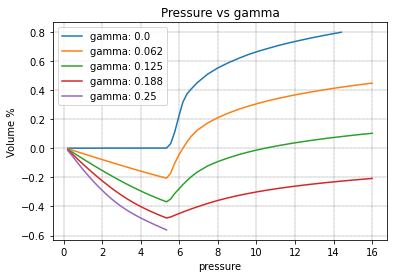

In [20]:
from matplotlib import pyplot as plt
grid = plt.grid(color='r', linestyle='-', linewidth=2)
fig, ax = plt.subplots(1,1)
legends = []
for (name, group) in vol_df_grouped:
    group.plot(kind='line',x='pressure',y='perc_vol',ax=ax, title="Pressure vs gamma")
    legends.append("gamma: {v}".format(v=np.round(name,3)))
    # group.plot(kind='line',x='pressure',y='perc_vol', ax=ax, secondary_y=True)
    # group.plot(x =['pressure', 'pressure'], y=['volume', 'perc_vol'], title=name, secondary_y=True, grid=grid)
ax.grid(color='k', linestyle='--', linewidth=0.25)
ax.legend(legends)
ax.set_ylabel("Volume %")


Text(0, 0.5, 'Volume [ml]')

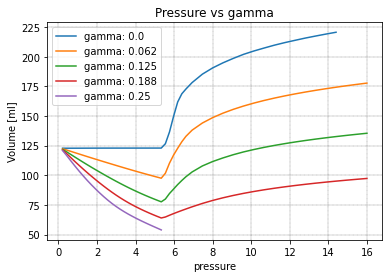

In [21]:
from matplotlib import pyplot as plt
grid = plt.grid(color='r', linestyle='-', linewidth=2)
fig2, ax2 = plt.subplots(1,1)
legends = []
for (name, group) in vol_df_grouped:
    group.plot(kind='line',x='pressure',y='volume',ax=ax2, title="Pressure vs gamma")
    legends.append("gamma: {v}".format(v=np.round(name,3)))
    # group.plot(kind='line',x='pressure',y='perc_vol', ax=ax, secondary_y=True)
    # group.plot(x =['pressure', 'pressure'], y=['volume', 'perc_vol'], title=name, secondary_y=True, grid=grid)
ax2.grid(color='k', linestyle='--', linewidth=0.25)
ax2.legend(legends)
ax2.set_ylabel("Volume [ml]")

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

pp = PdfPages('Pressure-vs-gamma.pdf')
pp.savefig(fig1)
pp.savefig(fig2)
pp.close()